In [1]:
from numpy import array,ones,tile,concatenate
from scipy.sparse import spdiags,identity
from scipy.sparse.linalg import spsolve


def laplaceNeumanBdry(row,column):
    # implements the 2d Laplace operator on a rectangle with Neuman boundary data
    dim=row*column
    outerblock=ones((dim,1))
    h=ones((row,1))
    h[row-1,0]=0
    subdiagonal=tile(h,(column,1))
    h=ones((row,1))
    h[0,0]=0
    superdiagonal=tile(h,(column,1))
    h=-4*ones((row,1))
    h[row-1,0]=-3
    h[0,0]=-3
    innerblocks=tile(h,(column-2,1))
    h=-3*ones((row,1))
    h[row-1,0]=-2
    h[0,0]=-2
    diagonal=concatenate((h,innerblocks),axis=0)
    diagonal=concatenate((diagonal,h),axis=0)
    B=concatenate((outerblock,subdiagonal,diagonal,superdiagonal,outerblock),axis=1)
    index=[-row,-1,0,1,row]
    A=spdiags(B.transpose(),index,dim,dim)
    return A*dim
    
def implicitEuler(x,tau,A):
    # performs an implicit Euler step of length tau for x'=Ax assuming A is sparse 
    return spsolve(identity(max(A.shape))-tau*A,x)


def applyOperator(x,laplace):
    # maps the initial condition of the heat equation to its solution
    tau=0.001
    timeSteps=10
    for kkk in range(timeSteps):
        x=implicitEuler(x,tau,laplace)
    return x

def applyAdjoint(x,laplace):
    # the adjoint mapping to applyOperator
    return applyOperator(x,laplace)


from numpy import array,load,zeros,ogrid,broadcast_arrays
from numpy.random import normal
from numpy.linalg import norm

def trueSolution(n,m):
    f=zeros([n,m])
    x,y=ogrid[0:1-1/n:n*1j,0:1-1/m:m*1j]
    x, y = broadcast_arrays(x, y)
    f[(1/8<=x) & (x<=1/4) & (1/8<=y) & (y<=5/8)]=2
    f[(1/8<=y) & (y<=1/4) & (1/8<=x) & (x<=5/8)]=2
    z=(x-2/3)**2+(y-2/3)**2
    f[z<=1/16]=-1
    return f

# true data
fDagger=trueSolution(50,50).ravel()
gDagger=applyOperator(fDagger,laplaceNeumanBdry(50,50))

# noisy data
noise=normal(0,1,gDagger.size)
relNoise=0.005
gDelta=gDagger+relNoise*norm(gDagger)*noise/norm(noise)

#Use the following in order to plot your solutions:
#import matplotlib.pyplot as plt
#f.shape=[50,50]
#plt.imshow(f)
#plt.colorbar()
#plt.show()

We start by implementing the Landweber method. Note that $\|T^*T\|$=1 (you can test that after you set up the matrix for Tikhonov) hence $\mu=1/2$ is a valid choice.

In [2]:
from numpy import zeros

f=zeros(fDagger.shape)

def landweber(f,data,mu,k):
    laplace=laplaceNeumanBdry(50,50)
    for jjj in range(k):
        f=f-mu*(applyAdjoint(applyOperator(f,laplace)-data,laplace))
    return f

f1=landweber(f,gDelta,1./2,10)
f2=landweber(f,gDelta,1./2,20)
f3=landweber(f,gDelta,1./2,50)
f4=landweber(f,gDelta,1./2,100)
f5=landweber(f,gDelta,1./2,400)
errors=array([norm(f1-fDagger),norm(f2-fDagger),norm(f3-fDagger),norm(f4-fDagger),norm(f5-fDagger)])/(norm(fDagger))

print(errors)

[ 0.69037686  0.65694459  0.61951346  0.58718087  0.52962073]


We see that for the testet number of iterations the quality of the reconstruction is still improving.

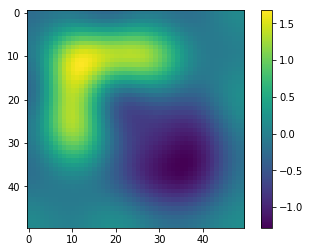

In [3]:
import matplotlib.pyplot as plt

f5.shape=[50,50]
plt.imshow(f5)
plt.colorbar()
plt.show()

Next we do the $\nu$-methods

In [4]:
def nuMethod(f,data,mu,nu,k):
    laplace=laplaceNeumanBdry(50,50)
    fOld=zeros(f.shape)
    fCurrent= ((4*nu+2)/(4*nu+1))*mu*(applyAdjoint(data,laplace))
    for jjj in range(2,k+1):
        theta=(jjj-1)*(2*jjj-3)*(2*jjj+2*nu-1)/(jjj+2*nu-1)/(2*jjj+4*nu-1)/(2*jjj+2*nu-3)
        omega=4*(2*jjj+2*nu-1)*(jjj+nu-1)/(jjj+2*nu-1)/(2*jjj+4*nu-1)
        fNew=fCurrent+theta*(fCurrent-fOld)+omega*mu*applyAdjoint(data-applyOperator(fCurrent,laplace),laplace)
        fOld=fCurrent
        fCurrent=fNew
    return fCurrent

f1=nuMethod(f,gDelta,1./2,2,10)
f2=nuMethod(f,gDelta,1./2,2,20)
f3=nuMethod(f,gDelta,1./2,2,50)
f4=nuMethod(f,gDelta,1./2,2,100)
f5=nuMethod(f,gDelta,1./2,2,400)
errors=array([norm(f1-fDagger),norm(f2-fDagger),norm(f3-fDagger),norm(f4-fDagger),norm(f5-fDagger)])/(norm(fDagger))

print(errors)

[ 0.63767757  0.58141715  0.51606065  0.48344883  0.44971086]


Again more iterations are better, note however that for the same number of iterations (which also means the same number of operator applications) the results are far better then with the Landweber method.

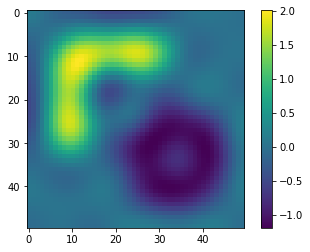

In [5]:
f5.shape=[50,50]
plt.imshow(f5)
plt.colorbar()
plt.show()

Last we do Tikhonov for which we have to set up a matrix, note that due to the linearity this can be done by applying the operator to "unit vectors" of initial data, so we have to evaluate our operator 2500 times! As $T=T^*$ we do not have to compute the transposed seperatly. 

In [7]:

def diffusionMatrix(row,column):
    dim=row*column
    T=zeros((dim,dim))
    laplace=laplaceNeumanBdry(row,column)
    for jjj in range(dim):
        T[:,jjj]=getColumn(jjj,dim,laplace)
    return T

def getColumn(jjj,dim,laplace):
    tau=0.001
    timeSteps=20
    x=zeros((dim,1))
    x[jjj,0]=1
    for kkk in range(timeSteps):
        x=implicitEuler(x,tau,laplace)
    return x

from numpy.linalg import solve
from numpy import eye

def tikhonov(f,T,data,alpha):
    [n,m]=T.shape
    f=solve(alpha*eye(m)+T.transpose()@T,T.transpose()@data+alpha*f)
    return f

T=diffusionMatrix(50,50)

f1=tikhonov(f,T,gDelta,1./10)
f2=tikhonov(f,T,gDelta,1./25)
f3=tikhonov(f,T,gDelta,1./50)

errors=array([norm(f1-fDagger),norm(f2-fDagger),norm(f3-fDagger)])/(norm(fDagger))

print(errors)

[ 0.70696323  0.68023945  0.6972941 ]


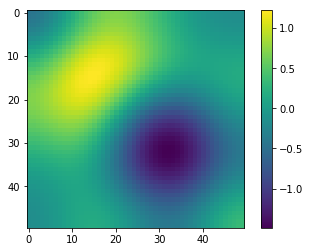

In [8]:
f2.shape=[50,50]
plt.imshow(f2)
plt.colorbar()
plt.show()

An advantage of the iterative methods it that they can be setup without knowing the matrix (which takes up a large set of memory and a lot of computing time especially if we discetize on a finer grid) compared to our naive way of implementing Tikhonov regularization (note that there is actually a way which does not need the matrix representation, one could for example solve the corresponding minimization problem via the CG-method, which will then usually converge very fast). However the number of iterations one has to do for iterative methods is usually quiet large where solving the linear system correspoinding to Tikhonov regularization is usually quiet fast, hence ones the system is set up one can fastly solve for a a large amount of alpha's. 